This notebook generates Fig. 1.

# Import GLAD drifter data

In [1]:
# import numpy
import numpy as np

# import datetime
from datetime import datetime

# get parent directory of working directory
import os
parentdirectory = os.path.dirname(os.getcwd())

# Import pandas
import pandas as pd

# get data directory where preprocesed GDP drifter data is stored.
# All the GDP drifters which were continuously active from the 10/08/2012 to the 17/08/2012  are stored in this directory.
data_directory = parentdirectory+"/data/GLAD/Drifter_processed"

drifters = []

for r, d, f in os.walk(data_directory):
    # r=root, d=directories, f = files
    for file in f:
        if file.endswith(".csv"):
            csv_file = pd.read_csv(r+"/"+file).values
            time_string = csv_file[:,0]
            time_datetime = [datetime.strptime(s, '%Y-%m-%d %H:%M:%S') for s in time_string]
            time_seconds = [0]
            for i in range(len(time_datetime)-1):
                time_seconds.append(int((time_datetime[i+1]-time_datetime[0]).total_seconds()))
            longitude = csv_file[:,1]
            latitude = csv_file[:,2]
            drifters.append([time_seconds, longitude, latitude])

# Import Chlorophyl data

In [2]:
# import netCDF
from netCDF4 import Dataset, num2date

def import_Chlorophyll(nc_file):

    fileobj = Dataset(nc_file, 'r')
    # only extract chlorophyll in the region of interest (=GOM)
    long_chl = fileobj.variables['lon'][2150:2260]
    lat_chl = fileobj.variables['lat'][1450:1570]
    CHL = fileobj.variables['chlor_a'][1450:1570,2150:2260]
    
    CHL_original = CHL.copy()
    
    # for plotting purposes: mask the values of CHL which are greater than 0.5 with 0.5
    CHL[CHL > 0.5] = 0.5
    
    return long_chl, lat_chl, CHL, CHL_original

long_chl, lat_chl, CHL, CHL_original = import_Chlorophyll(parentdirectory + "/data/GLAD/Chlorophyll/Composite_Chlorophyll.nc")

# Import Attracting LCS

The attracting LCS is computed from backwards trajectories over the time-interval $ [222 \ \mathrm{doy}, 229 \ \mathrm{doy}] $ from the geostrophic velocity field (=AVISO). The computation is done using the [TBarrier](https://github.com/EncinasBartos/TBarrier) notebook series.

In [3]:
# import scipy
from scipy.io import loadmat

AttractingLCS = loadmat("AttractingLCS.mat")
AttractingLCS_x = AttractingLCS["attractingLCS_x"]
AttractingLCS_y = AttractingLCS["attractingLCS_y"]

# Evolution of drifter array over the chlorophyll distribution

  0%|          | 0/4 [00:00<?, ?it/s]

C:\Users\encin\anaconda3\envs\Chaos\lib\site-packages\ipykernel_launcher.py:172: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "tight_layout" which is no longer supported as of 3.3 and will become an error two minor releases later


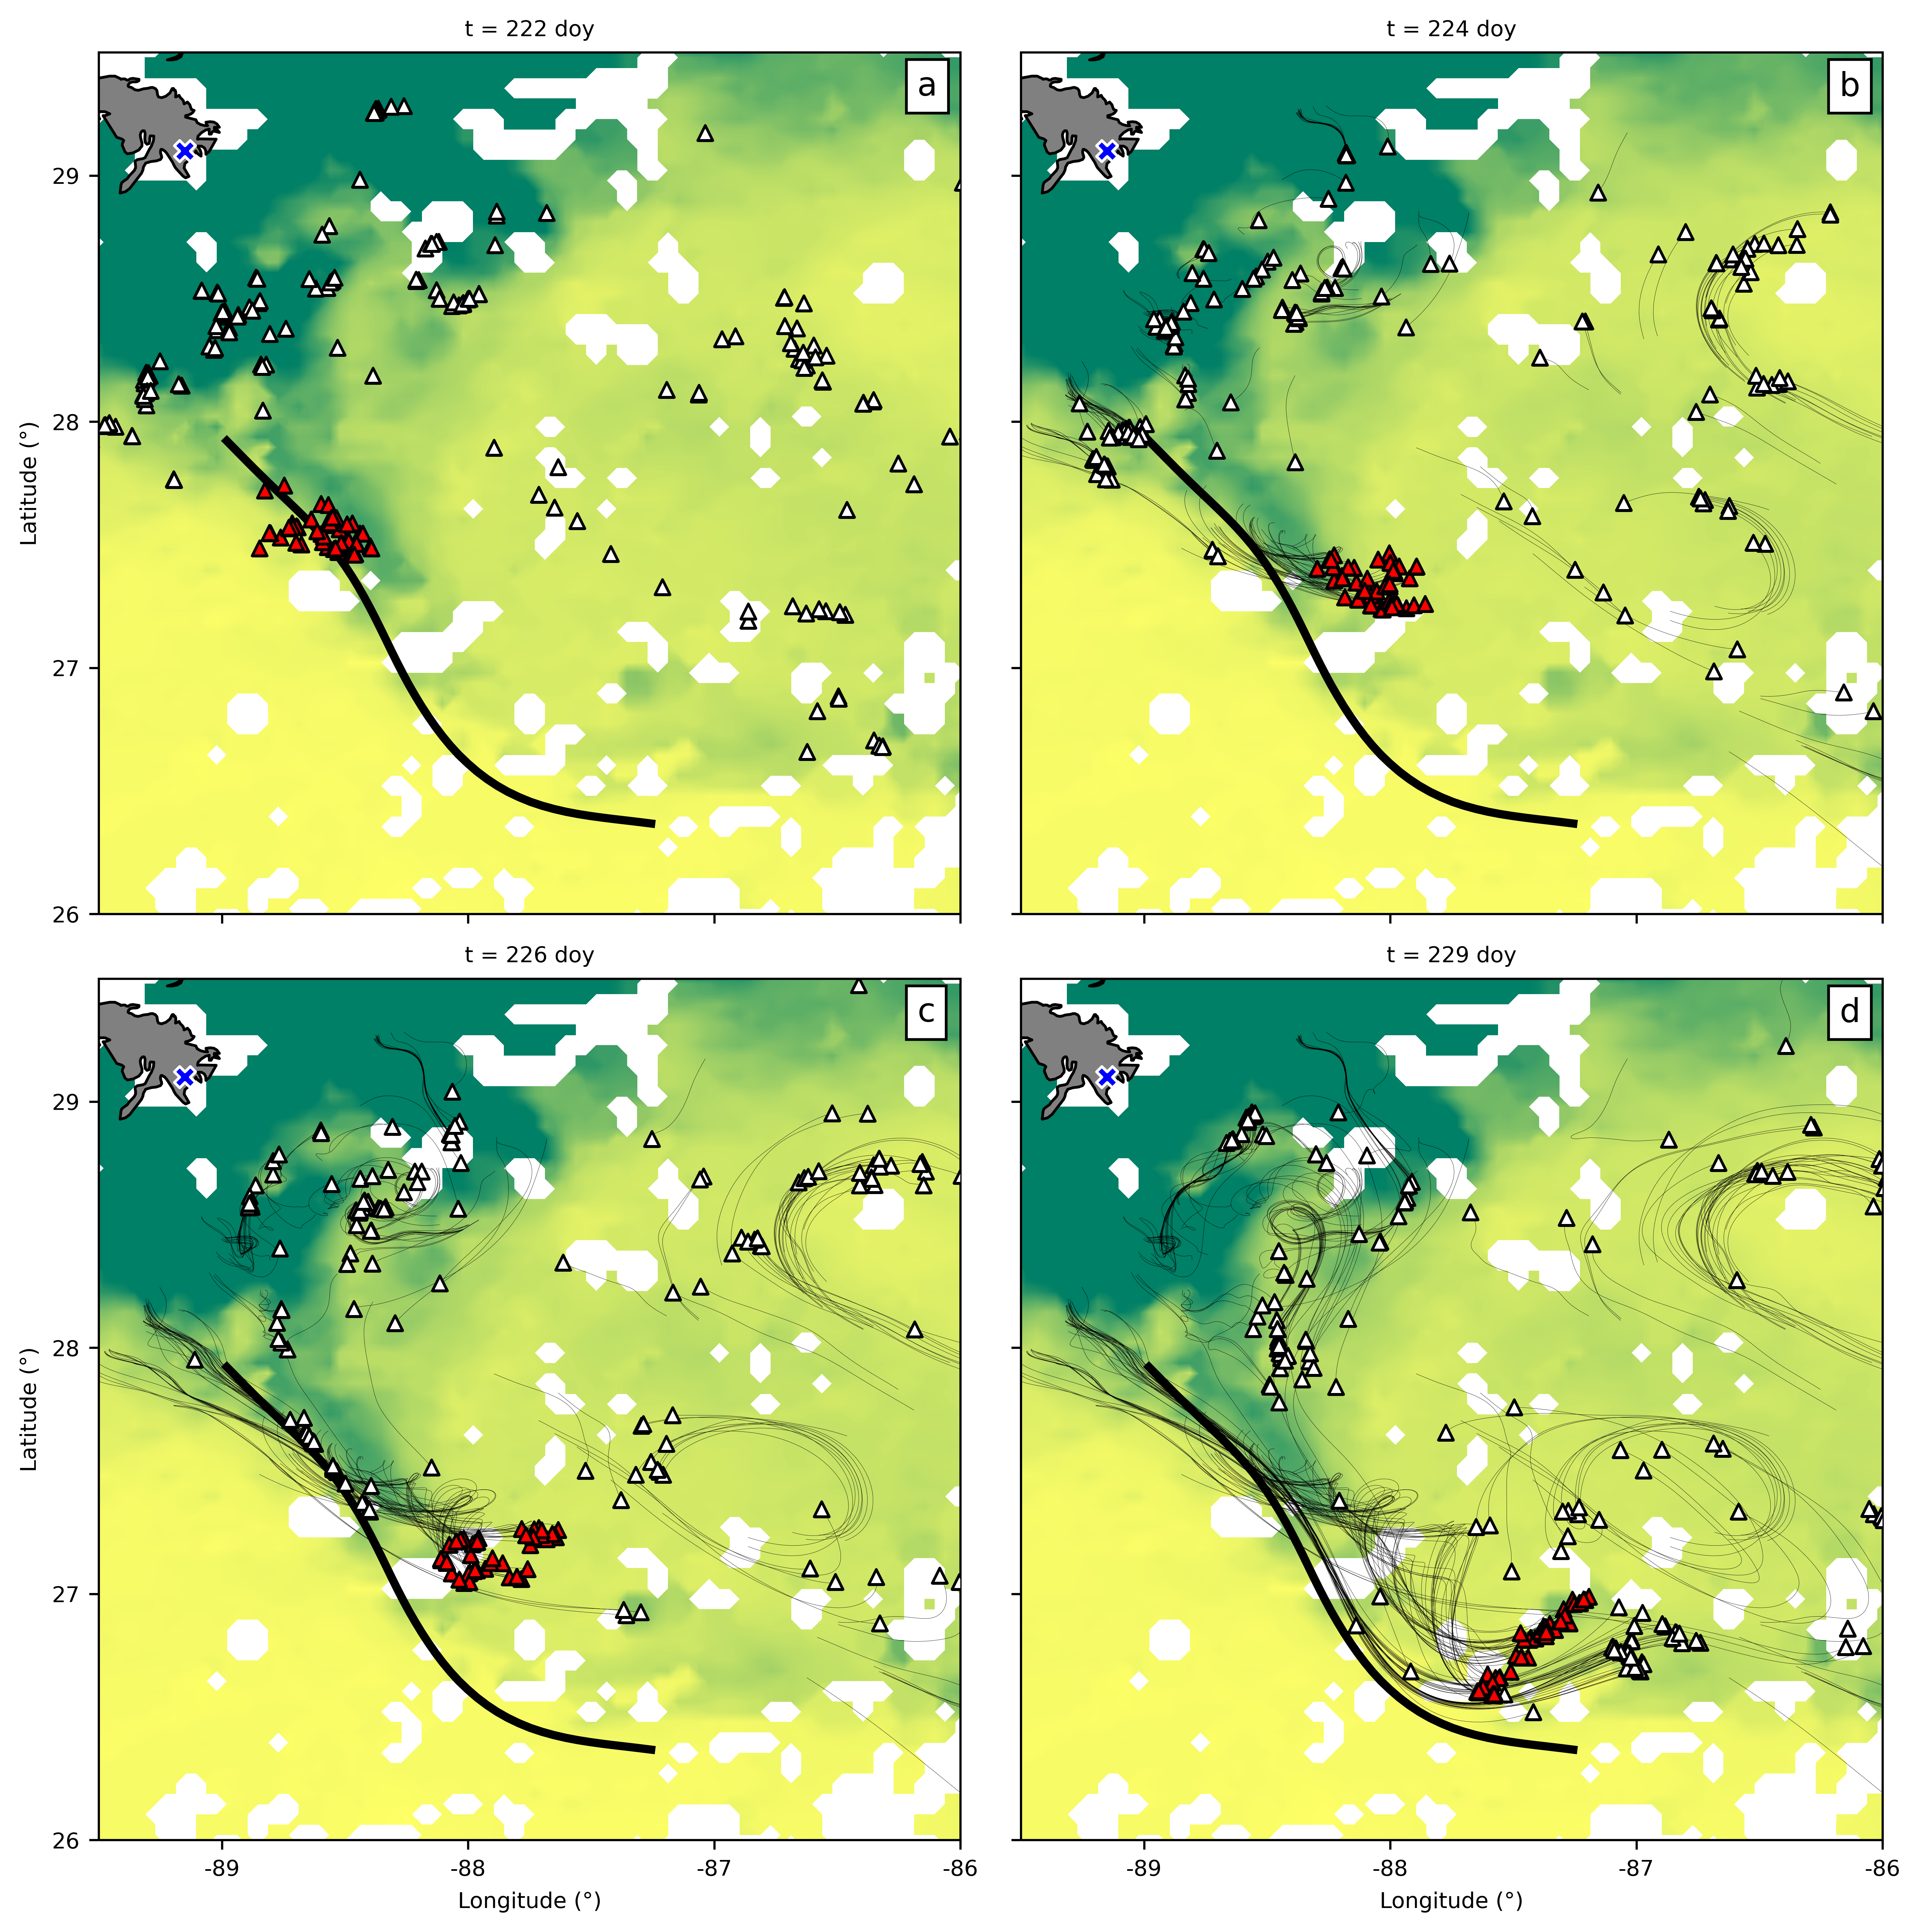

In [5]:
# Import plotting package
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset

# Import datetime
from datetime import timedelta

# import package for progress bar
from tqdm.notebook import tqdm

# import cartopy for coastal borders
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# suppress deprecation warning from cartopy library
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

fig1 = plt.figure(figsize = (12, 12), dpi = 600)
ax = []
idx_list = np.arange(0, 96*7+1, 96)
idx_list = [0, 2*96, 4*96, 7*96]

idx_x = [0, 1, 0, 1]
idx_y = [0, 0, 1, 1]

letters = ["a", "b", "c", "d"]

# Set initial and final date
date_initial = datetime(2012, 8, 10, 0, 0, 0)
date_final = datetime(2012, 8, 17, 0, 0, 0)

# Set counter
counter = 0

# Define limits
long_limits = [-89.5, -86]
lat_limits = [26, 29.5]

long_min = long_limits[0]
long_max = long_limits[-1]
lat_min = lat_limits[0]
lat_max = lat_limits[-1]

# Mouth of Mississippi river
long_Mississippi = -89.15
lat_Mississippi = 29.1

delta_long = long_limits[-1]-long_limits[0]
delta_lat = lat_limits[-1]-lat_limits[0]

# Iterate over time-series/subplots
for idx in tqdm(idx_list):
    
    date = date_initial + timedelta(hours = int(idx/4))
    
    filesave = r'./figures/fig1.jpg'
    
    long_cluster, lat_cluster = [], []
    long_rest, lat_rest = [], []
    long_current_cluster, lat_current_cluster = [], []
    long_current_rest, lat_current_rest = [], []
    
    # time
    time = drifters[0][:idx+1]
    
    longitude, latitude = [], []
    
    for d in drifters:
        
        #longitudinal position of drifter d
        long = d[1][:idx+1]
        long_final = d[1][-1]
        
        # latitudinal position of drifter d
        lat = d[2][:idx+1]
        lat_final = d[2][-1]
        
        long_init = d[1][0]
        lat_init = d[2][0]
        
        # Append longitude/latitude
        longitude.append(long)
        latitude.append(lat)
        
        # manually mark clustered red drifters
        if -89 < long_init < -88 and 27.25 < lat_init< 28:
            
            # store
            long_cluster.append(long)
            lat_cluster.append(lat)
            
            # store current position
            long_current_cluster.append(long[idx])
            lat_current_cluster.append(lat[idx])
        
        else:
            
            long_rest.append(long)
            lat_rest.append(lat)
            
            # store current position
            long_current_rest.append(long[idx])
            lat_current_rest.append(lat[idx])
        
    # Date year
    yearday = (date - datetime(2012, 1, 1, 0, 0, 0)).total_seconds() / (3600 * 24)

    ax.append(plt.subplot(2, 2, counter+1, projection=ccrs.PlateCarree())) #PlateCarree
    
    # Set cartopy features    
    ax[-1].natural_earth_shp(name='land', resolution='10m', category='physical', facecolor = "grey")
    ax[-1].coastlines(resolution = "10m", edgecolor = "k")
    
    # Plot mouth of Mississippi-river
    ax[-1].scatter(long_Mississippi, lat_Mississippi, marker = "X", s = 60, facecolors = "b", edgecolors = "w", zorder = 2)
    
    # Set title (=date)
    ax[-1].set_title("t = " + np.str(int(yearday)) + " doy", fontsize = 8)

    # Set limits
    ax[-1].set_xlim([long_min, long_max])
    ax[-1].set_ylim([lat_min, lat_max])
    
    # Define position of the letters
    long_letter = long_min + 0.9*(long_max-long_min)
    lat_letter = lat_min + .9*(lat_max - lat_min)
    
    # Plot letters
    ax[-1].text(.95, .95, letters[counter], c = "k", fontsize = 12, bbox = dict(facecolor='w', edgecolor='k'), transform = ax[-1].transAxes)
    
    # Plot chlorophyll
    cax = ax[-1].contourf(long_chl, lat_chl, CHL, levels=300, cmap='summer_r', zorder=1)
    
    # Plot drifters
    ax[-1].scatter(long_current_rest, lat_current_rest, s=30, marker="^", facecolor = "w", edgecolor = "k", zorder=3)
    ax[-1].scatter(long_current_cluster, lat_current_cluster, s=30, marker="^", facecolor = "r", edgecolor = "k", zorder=3)
    
    # Plot drifter tails
    for ti in range(len(longitude)):
        ax[-1].plot(longitude[ti], latitude[ti], linewidth = 0.1, c = "k")
    
    # Set ticks
    ax[-1].set_yticks(np.arange(lat_min, lat_max+.1, 1, dtype = int))
    ax[-1].set_xticks(np.arange(long_min+.5, long_max+.1, 1, dtype = int))
    
    # Set labels, ticks, ticklabels
    if idx_x[counter] == 0:
        ax[-1].set_ylabel("Latitude (°)", fontsize = 8)
        ax[-1].set_yticklabels(np.arange(lat_min, lat_max+.1, 1, dtype = int), fontsize = 8)
        
    else:
        
        ax[-1].set_yticklabels([])
        
    if idx_y[counter] == 1:
        ax[-1].set_xticklabels(np.arange(long_min+.5, long_max+.1, 1, dtype = int), fontsize = 8)
        ax[-1].set_xlabel("Longitude (°)", fontsize = 8)

    else:
        
        ax[-1].set_xticklabels([])
    
    # Plot AVISO-based attracting LCS
    ax[-1].plot(AttractingLCS_x[0,:50], AttractingLCS_y[0,:50], c = "k", linewidth = 3)
        
    plt.subplots_adjust(wspace=0.01, hspace=0.075)
    
    counter += 1

# savefig
plt.savefig(filesave, dpi=600, bbox_inches='tight', tight_layout=True)
plt.show(fig1)